In [1]:
# %load_ext autoreload
# %autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import pickle
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0,os.path.dirname(os.path.dirname(currentdir)))

from mlopt.mlopt.timeseries.AGMLP_Residual import AGMLP_Residual
from mlopt.mlopt.timeseries.AGMLP_Residual import AGMLP_VR_Residual
from mlopt.mlopt.timeseries.TimeSeriesUtils import *
from correctData import *
import copy

warnings.filterwarnings("ignore")

# Load and Process Data

In [2]:
inmet_csv = './historical_data_maceio.csv'
save_scaler = "resultados/MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 30*24

posicao_final=len(df_inmet)-1
posicao_inicial=posicao_final - ultimos_dias

df_inmet = df_inmet.iloc[posicao_inicial:,:]

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[:].values.reshape(-1,1)

print("data hora inicial: ", df_inmet.iloc[0,:].data, df_inmet.iloc[0,:].hora,
      "data hora final: ", df_inmet.iloc[-1,:].data,df_inmet.iloc[-1,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
#pickle.dump(MaxAbsScaler_gen, open(save_scaler, 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
data hora inicial:  2020-03-12 20 data ho

# SARIMAX 

## Auto ARIMA

In [8]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-1557.787, Time=10.24 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-717.270, Time=0.79 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1454.105, Time=6.70 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1225.230, Time=6.65 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-711.355, Time=0.25 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-1448.678, Time=10.88 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-1467.922, Time=8.85 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=-1559.195, Time=41.63 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-1504.052, Time=37.23 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=46.47 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=-1556.371, Time=42.65 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=-1576.824, Time=35.69 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=9.94 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=-1499.356, Time=36.26 sec
 ARIMA(1,0,

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 0, 2, 24),
      suppress_warnings=True)

In [9]:
mod = SARIMAX(endog=gen, exog=exog, order=(1,0,2), seasonal_order=(1,0,2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -1488.858732966085, Mape: 5.3497697460376346


## PSO-ACO Parametrization

In [4]:
p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, verbose=False)
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-01-31 22:30:15,939 - root - INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:15,939: INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:16,040 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,040: INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,048 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,048: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,052 - root - INFO - 5
2021-01-31 22:30:16,052: INFO - 5
2021-01-31 22:30:16,201 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.glob

In [90]:
# A variável exógena então escolhida fica sendo apenas a temperatura. O que faz todo o sentido...
mod = SARIMAX(endog=gen, exog=exog[:,[1,0,0,0]], order=(2,0,0), seasonal_order=(1,0,1, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -1519.18991387265, Mape: 6.56084020712168


### SARIMAX 1 day AHEAD

In [104]:
# nesse caso, para usar o get_forecast é preciso ter também as variáveis exógenas do dia da frente, apenas para teste
# vou deixar as mesmas do dia anterior
y_sarimax_ahead = results.get_forecast(24, exog=exog[-24:,[1,0,0,0]]).predicted_mean

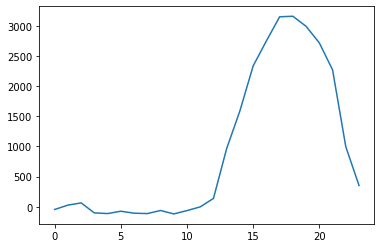

In [111]:
plt.plot(MaxAbsScaler_gen.inverse_transform(y_sarimax_ahead[-24:].reshape(-1,1)))

## DUMP Sarimax

In [19]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

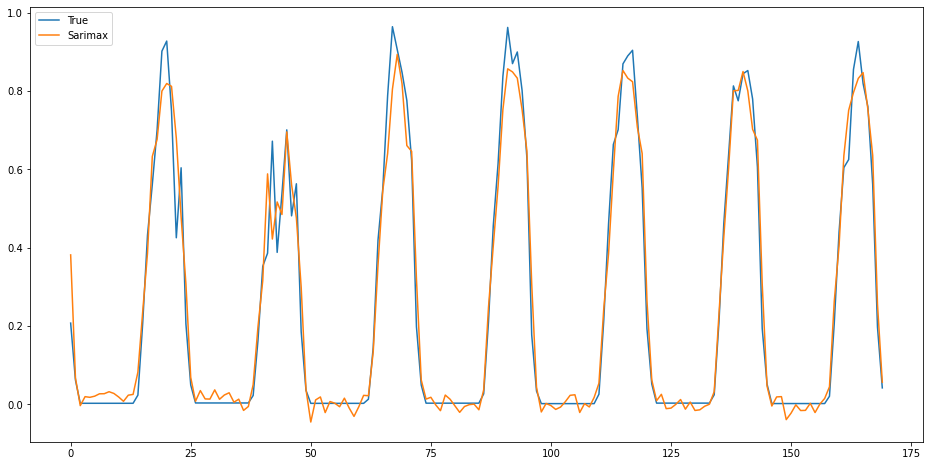

In [3]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

## Train

In [22]:
# ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12, prob_mut=0.8,
#                                  tr_ts_percents=tr_ts_percents).search_best_model()
# best_mlp_residual = ag_mlp_residual._best_of_all
#pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

  0%|          | 0/3 [00:00<?, ?it/s]generation: 0

100%|██████████| 3/3 [00:21<00:00,  7.06s/it]

100%|██████████| 3/3 [00:33<00:00, 11.09s/it]

100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

100%|██████████| 3/3 [00:50<00:00, 16.92s/it]

100%|██████████| 3/3 [00:12<00:00,  4.09s/it]

100%|██████████| 3/3 [00:21<00:00,  7.14s/it]

100%|██████████| 3/3 [00:28<00:00,  9.47s/it]

100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

100%|██████████| 3/3 [00:10<00:00,  3.33s/it]

100%|██████████| 3/3 [00:54<00:00, 18.04s/it]

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

100%|██████████| 3/3 [00:40<00:00, 13.44s/it]

100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

100%|██████████| 3/3 [00:41<00:00, 13.71s/it]

100%|██████████| 3/3 [00:15<00:00,  5.13s/it]

100%|██████████| 3/3 [00:40<00:00, 13.65s/it]

100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

100%|██████████| 3/3 [00:56<00:00, 18.98s/it]

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

100%|██████████| 3/3 [00:49<00:00, 16.64s/it]

100%|███

## Results

[17, 19, 3, 16, MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(68, 44, 5), max_iter=500), MLPRegressor(early_stopping=True, hidden_layer_sizes=(18, 12, 8),
             learning_rate='adaptive', max_iter=500, solver='lbfgs'), 0.02432105552993146]
Teste para saber se pegou o melhor mesmo! 0.02432105552993146 == 0.02432105552993146 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  84.8829484998448
HIBRIDO
MAE:  0.02432105552993146
MSE:  0.0018577701507670231
MAPE:  38.98334792175626
GANHO MAE:
0.3094881465536412
GANHO MSE:
0.3683526750329882
GANHO MAPE:
0.5407399411693676


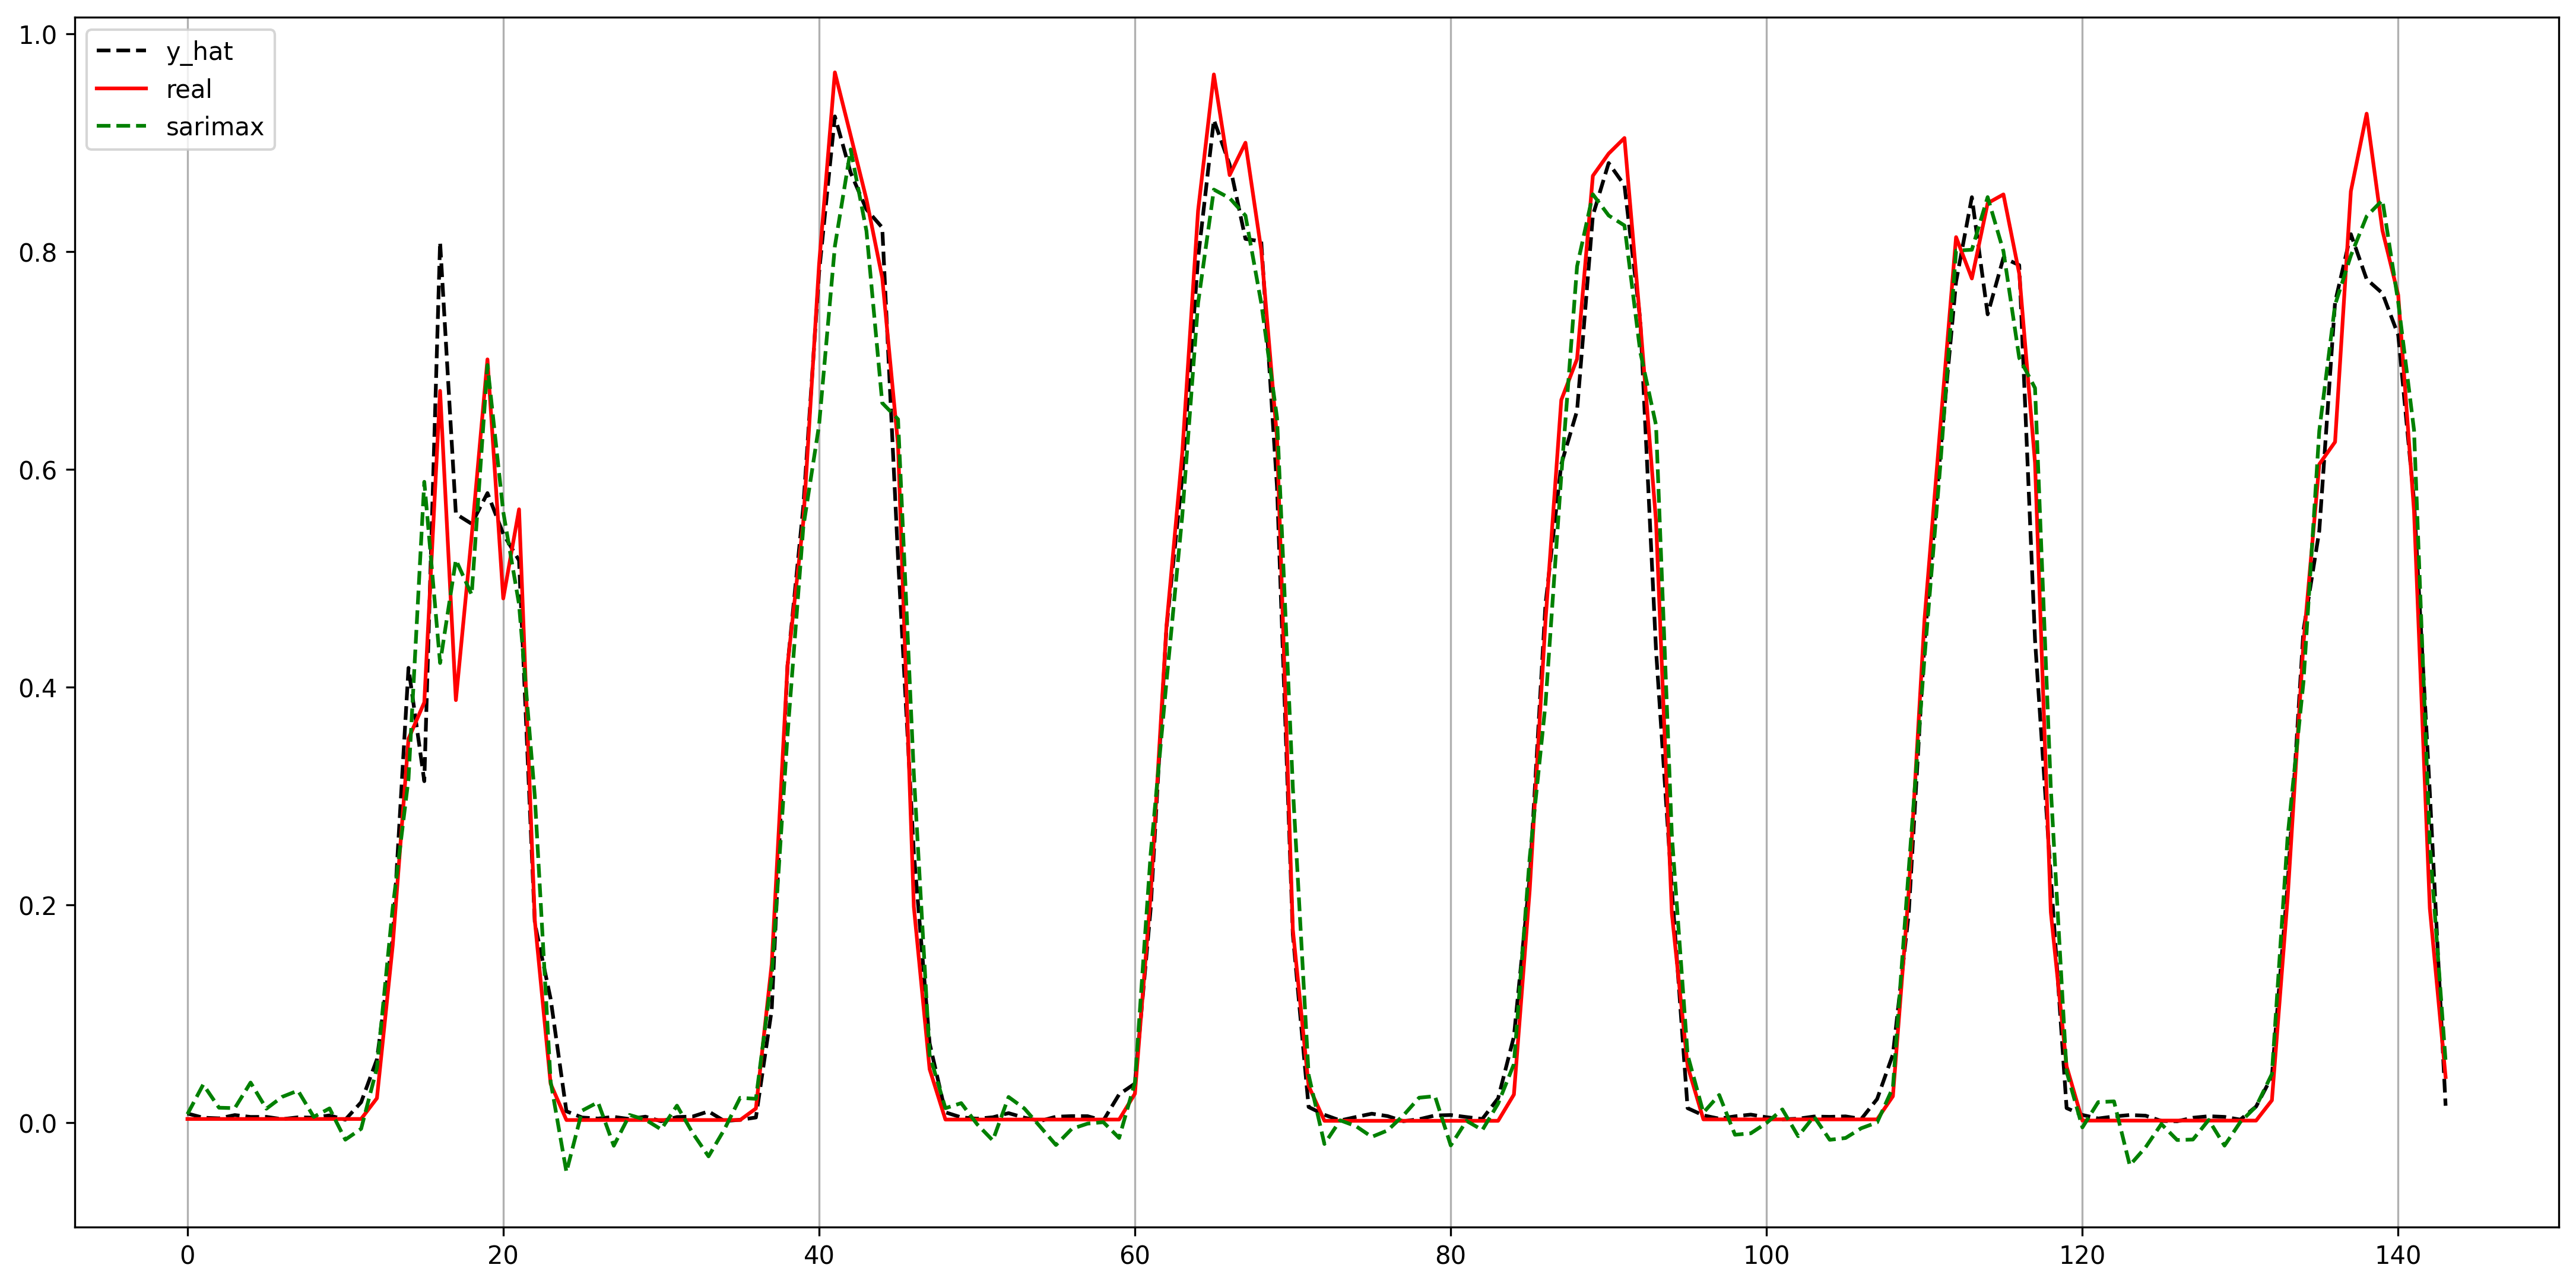

In [124]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

tr_ts_percents=[80,20]

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

In [128]:
np.savetxt("resultados/arrays/agmlp_residual.txt",y_estimado_so_test)

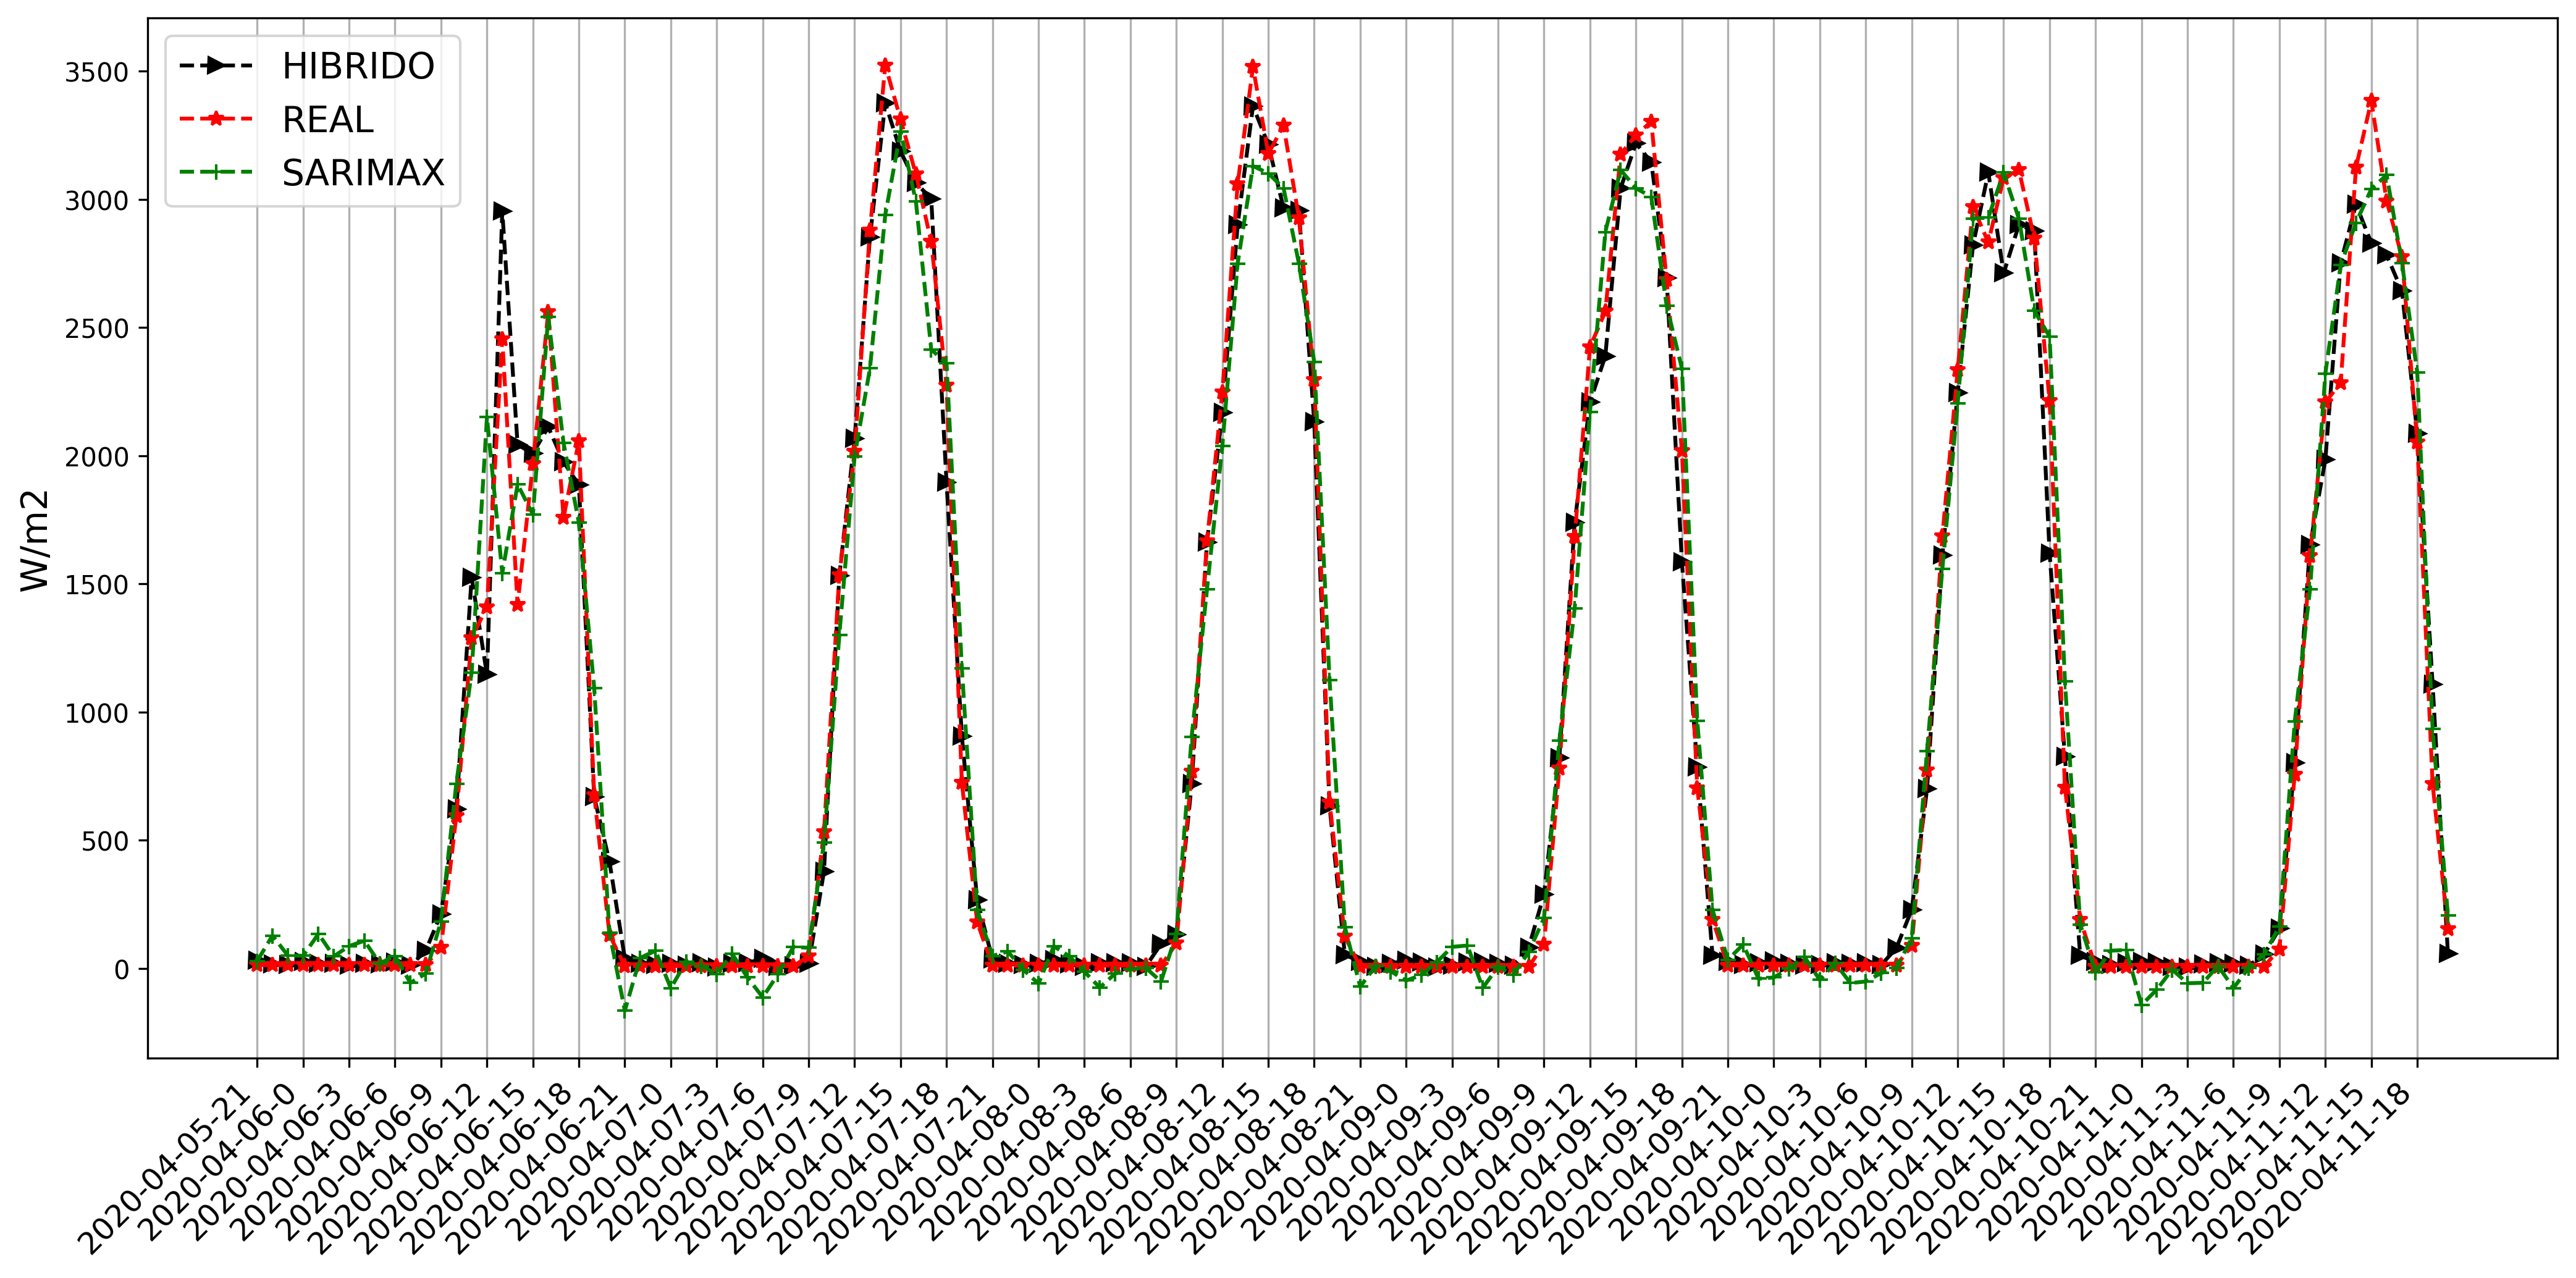

In [39]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=14)
ax.set_ylabel('W/m2', fontsize=14)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch3_pop12.png', dpi=300)

## 1 day ahead forecast

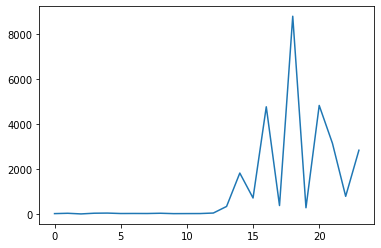

In [112]:
# aqui é um exemplo de como fazer 1 day ahead forecast com base no algoritmo
# esse exemplo é importante pq da para ver que tem como implementar. Porém 1 day ahead é muita coisa, visto
# que são usados dados horários, então obiviamente o resultado não é bom.

gen_day_ahead = gen.copy()
y_sarimax_day_ahead = y_sarimax.copy()

for i in range(24):
    
    erro_day_ahead = gen_day_ahead - y_sarimax_day_ahead

    erro_estimado_for_forecast = best[4].predict(erro_day_ahead[-best[0]:].reshape(1,-1))

    erro_fut = erro_day_ahead.copy()
    for _ in range(best[3]):
        erro_fut = np.append(erro_day_ahead, best[4].predict(erro_fut[-best[0]:].reshape(1,-1)))

    X_ass_1_forecast_in = y_sarimax_day_ahead[-best[1]-1:]
    X_ass_2_forecast_in = np.concatenate((erro_estimado_for_forecast[-best[2]-1:], erro_fut[-best[3]-1:]))

    X_in_forecast = np.concatenate((X_ass_1_forecast_in, X_ass_2_forecast_in))

    y_forecast = best[5].predict(X_in_forecast.reshape(1,-1))

    gen_day_ahead = np.append(gen_day_ahead, y_forecast)
    y_sarimax_day_ahead = np.append(y_sarimax_day_ahead, y_sarimax_ahead[i])
    
plt.plot(MaxAbsScaler_gen.inverse_transform(gen_day_ahead[-24:].reshape(-1,1)))

# Algoritmo AGMLP_VR_Residual

In [113]:
tr_ts_percents=[80,20]

## Train

In [127]:
ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12,
                                       prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0


  0%|          | 0/3 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0


 33%|███▎      | 1/3 [13:51<27:43, 831.64s/it]

generation: 1
start_set_fit: 2


 67%|██████▋   | 2/3 [24:48<12:08, 728.76s/it]

generation: 2
start_set_fit: 4


100%|██████████| 3/3 [36:48<00:00, 736.26s/it]


## Results

[11, 15, 17, 9, 38, <mlopt.mlopt.omodels.AgMlp.AgMlp object at 0x00000299811EA910>, <mlopt.mlopt.omodels.AgMlp.AgMlp object at 0x0000029985596730>, 0.02806684824936266]
Teste para saber se pegou o melhor mesmo! 0.02806684824936266 == <mlopt.mlopt.omodels.AgMlp.AgMlp object at 0x0000029985596730> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  84.8829484998448
HIBRIDO
MAE:  0.02806684824936266
MSE:  0.0022908519284767655
MAPE:  179.0195004837343
GANHO MAE:
0.20313937932447468
GANHO MSE:
0.2211035945859946
GANHO MAPE:
-1.1090160467748316


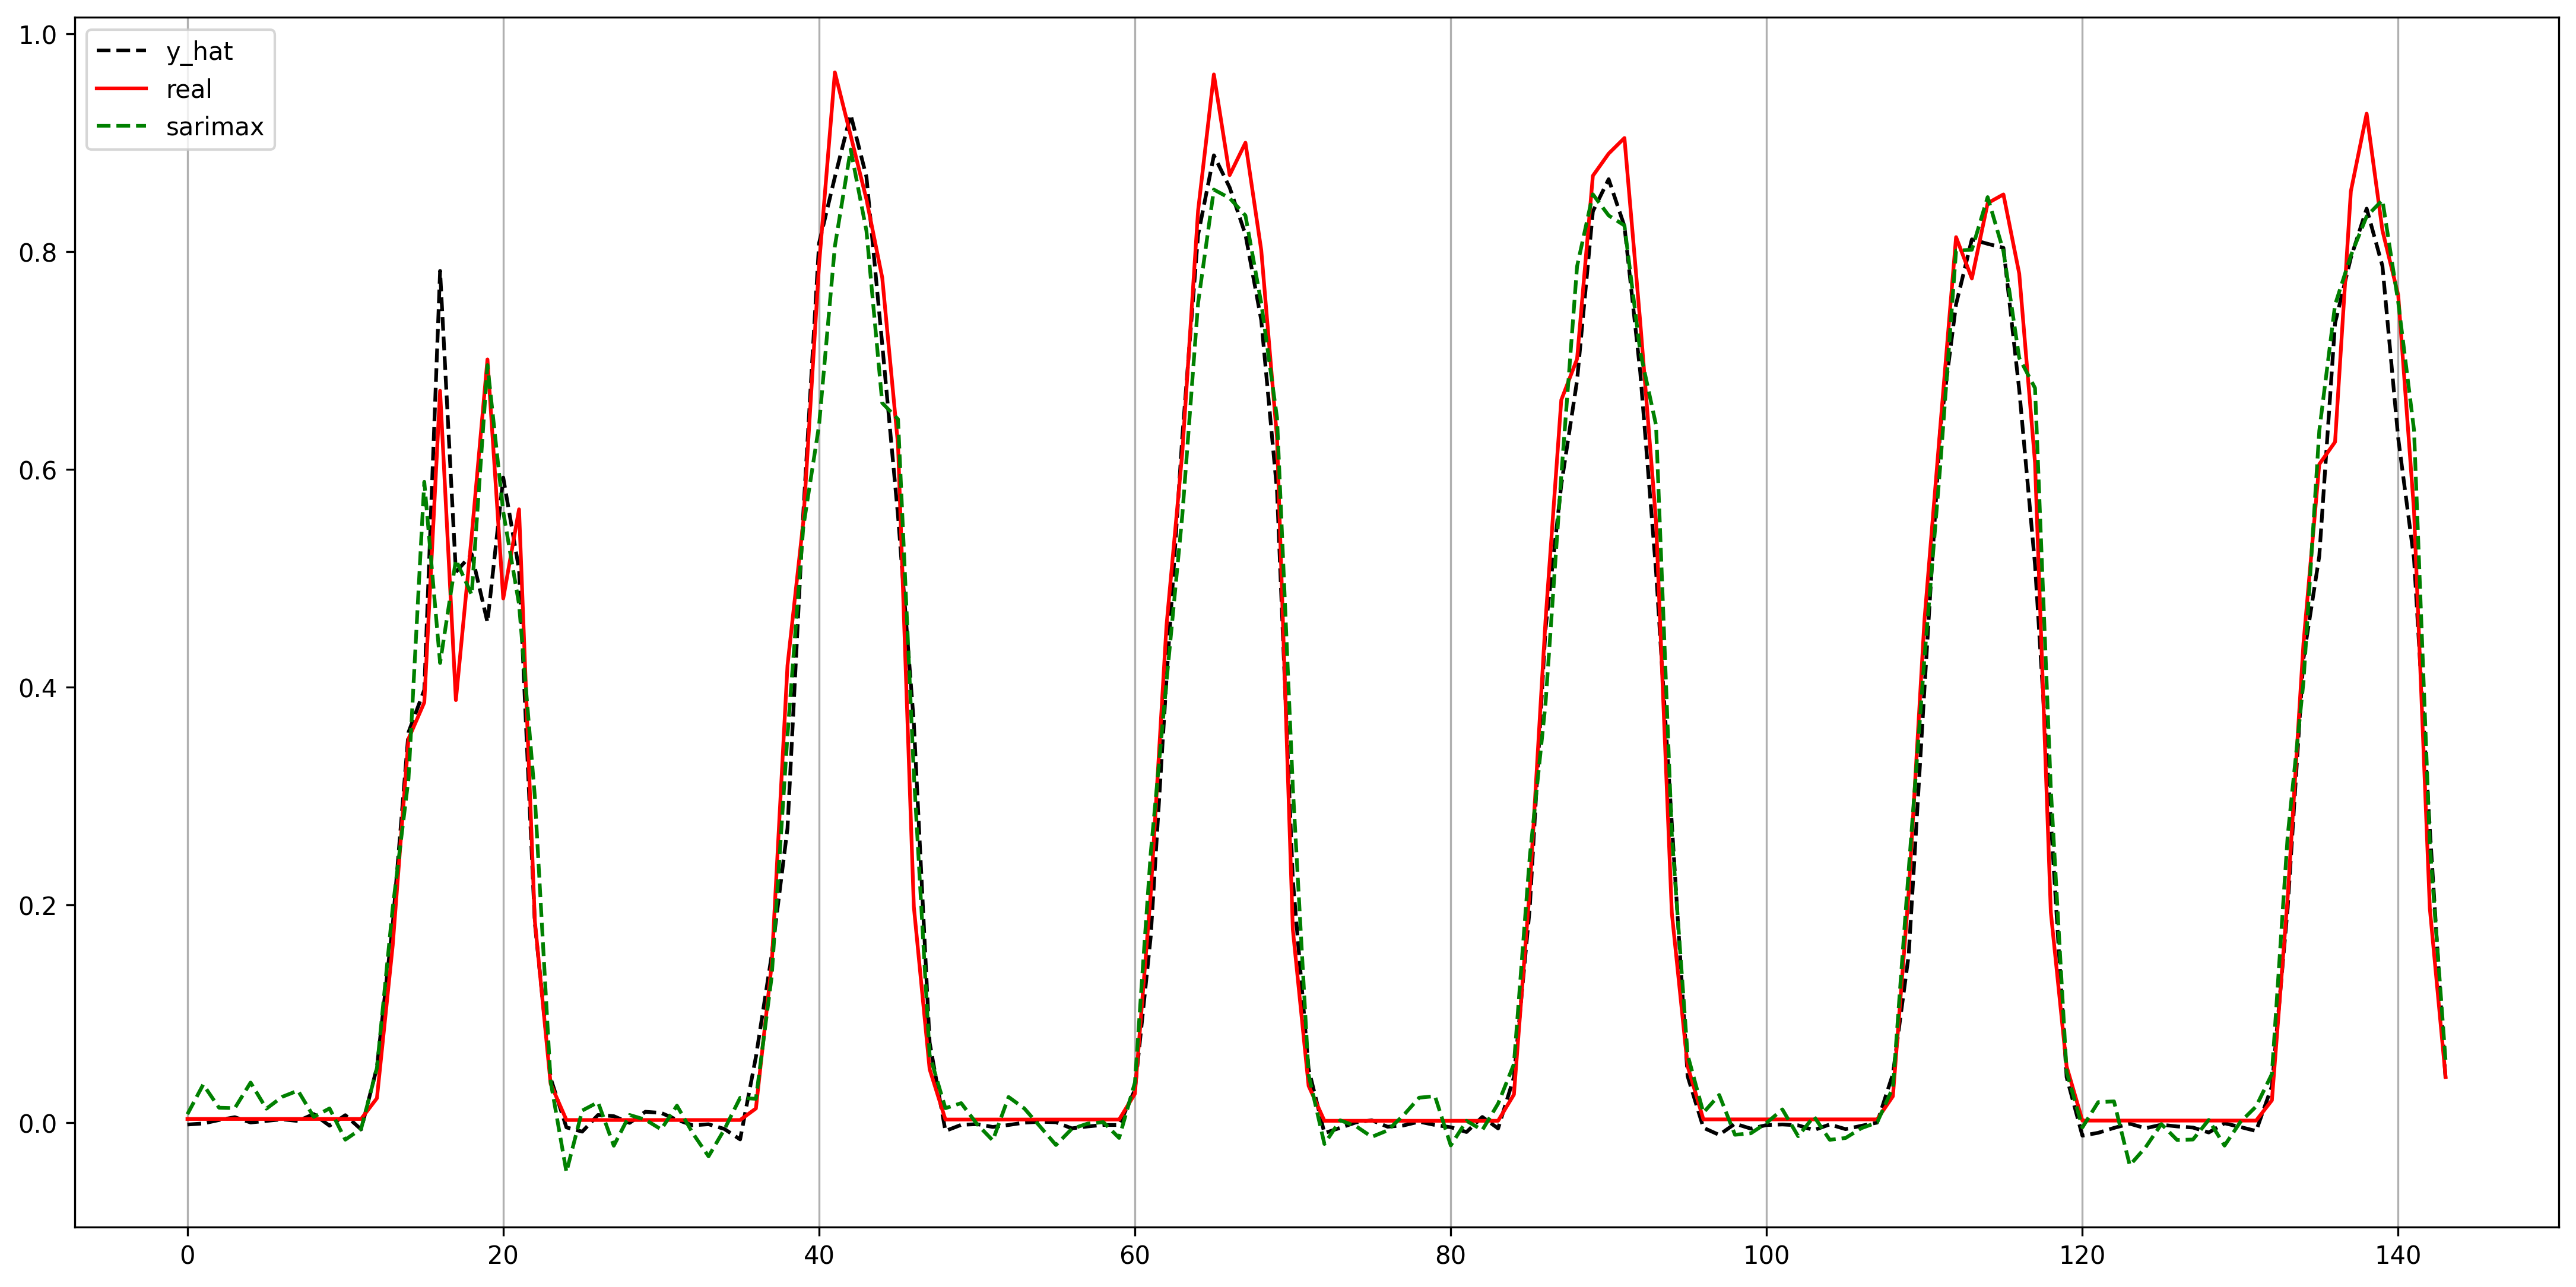

In [129]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

tr_ts_percents=[80,20]

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_vr_residual = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_vr_residual[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

In [130]:
np.savetxt("resultados/arrays/agmlp_ensemble_residual.txt",y_estimado_so_test)

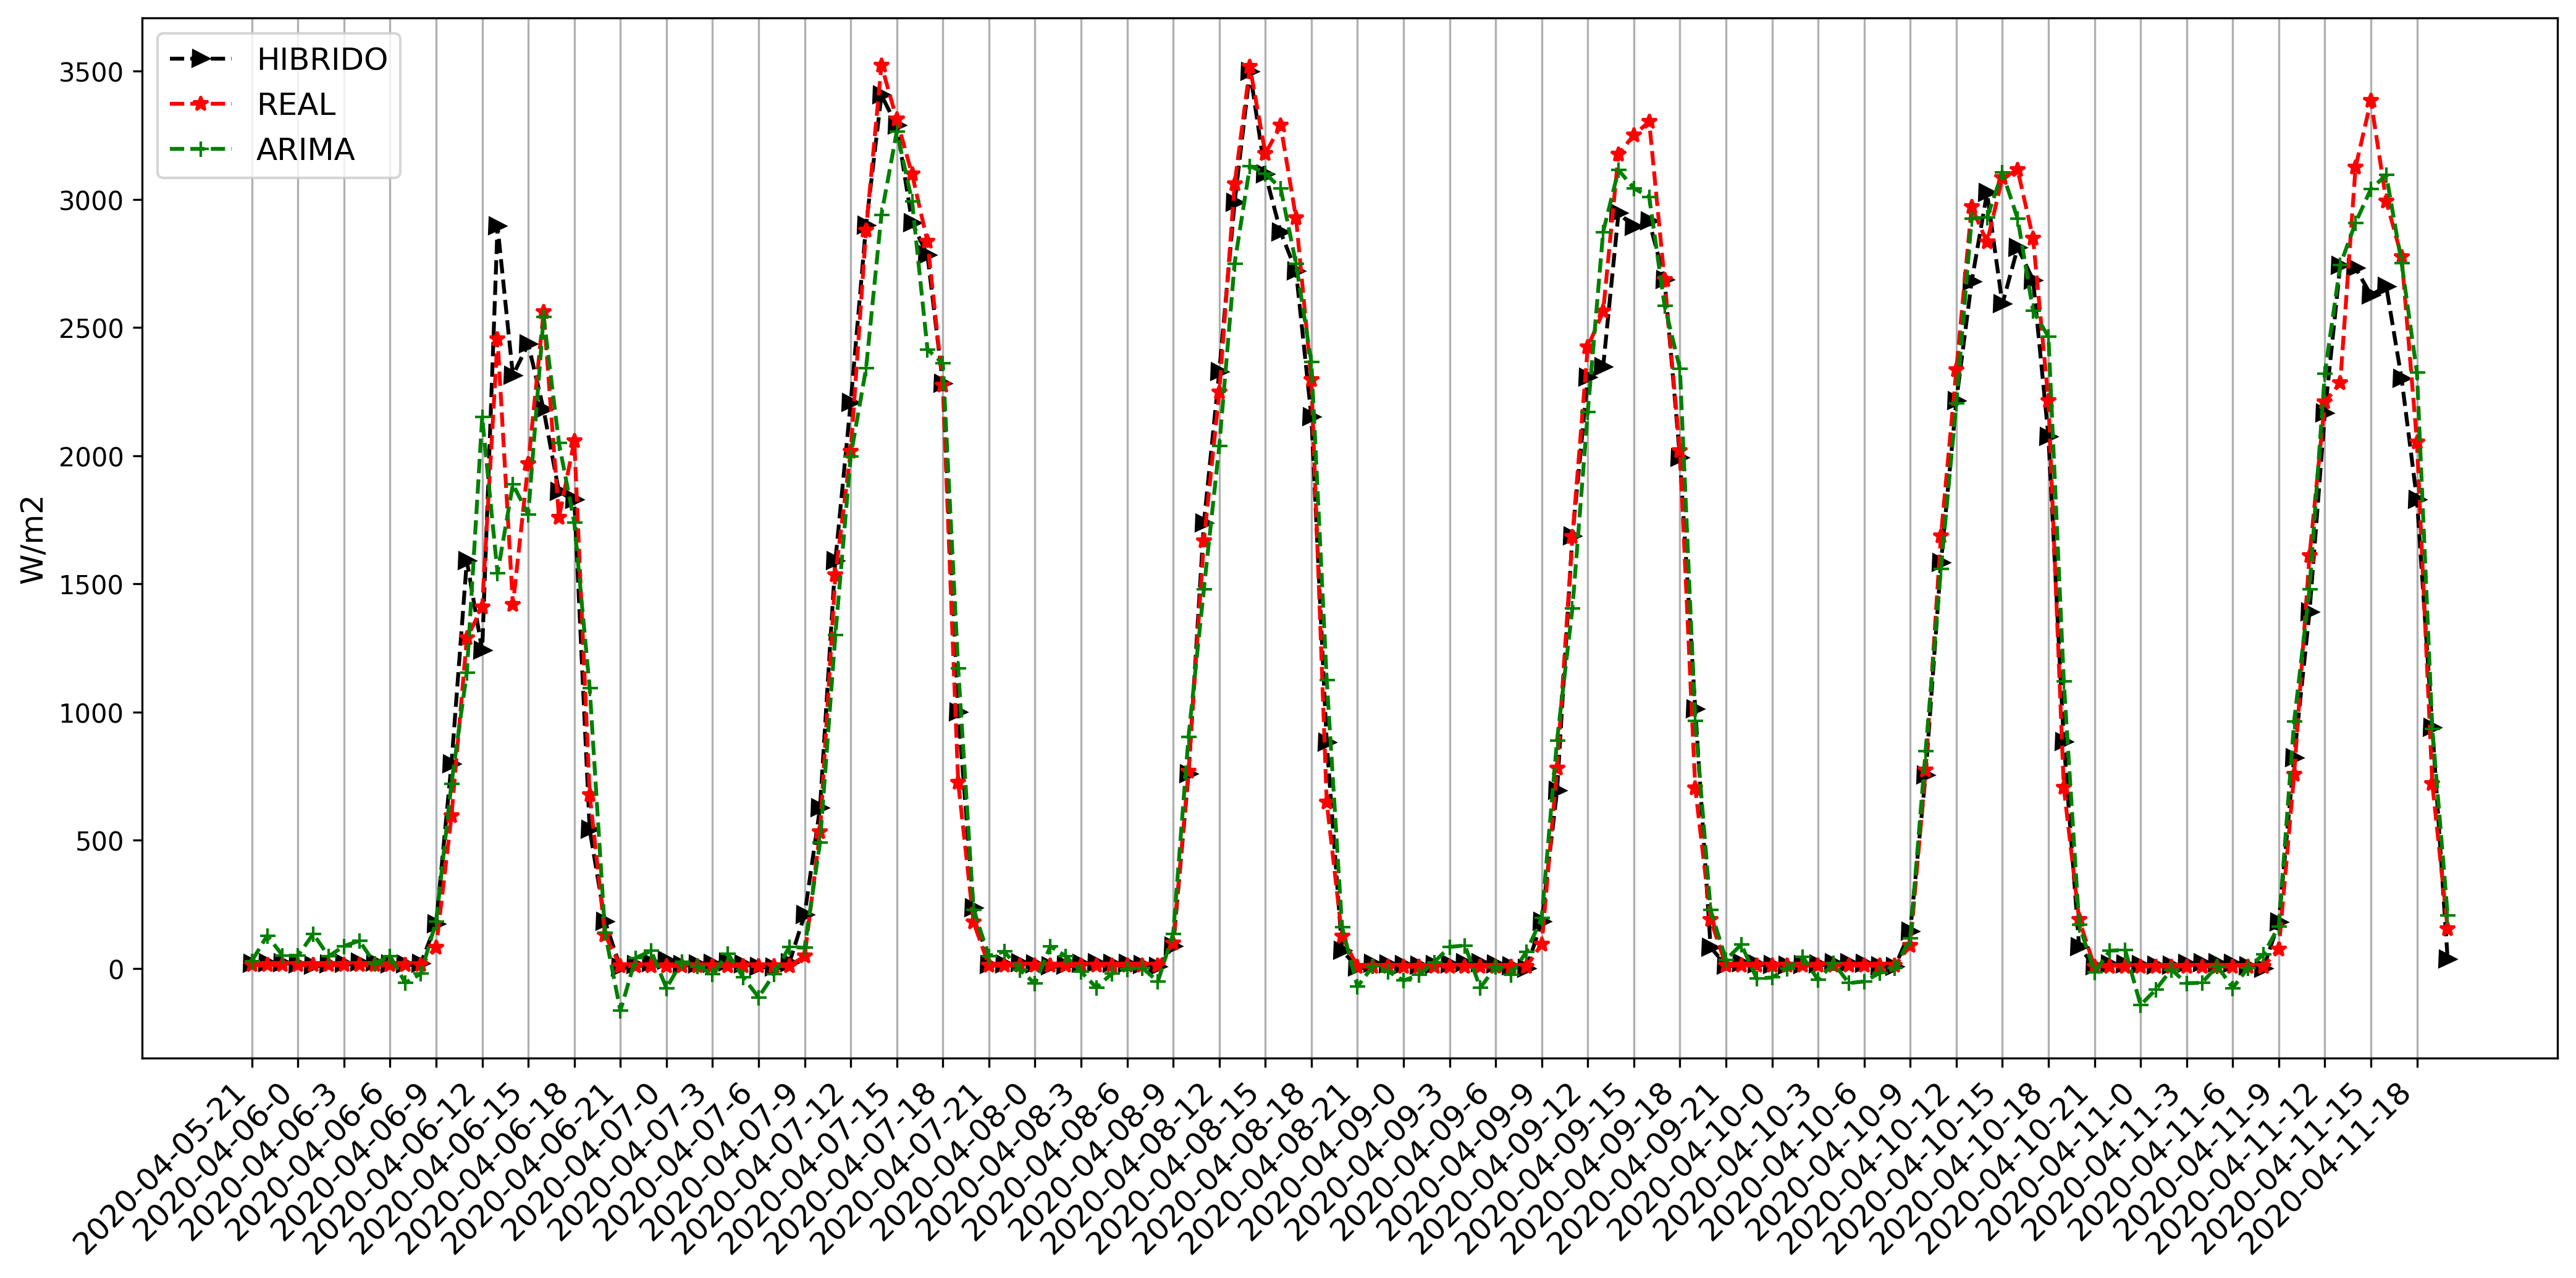

In [45]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpvrresidual_epoch3_pop12.png', dpi=300)

# LSTM

Without exogenous variables

https://www.sciencedirect.com/science/article/abs/pii/S0360544218302056

https://www.sciencedirect.com/science/article/abs/pii/S0960148120308557

## Train

In [44]:
# from mlopt.mlopt.omodels.ACOLSTM import ACOLSTM
# # Importing only here becouse TF takes too long to import

# options_ACO={'antNumber':2, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
# fl_qtn = [10, 30, 70, 100]
# fl_func = list(range(6))             
# sl_qtn = [5, 10, 20, 40]
# sl_func = list(range(6))
# tl_qtn = [1, 10, 15]
# tl_func = list(range(6))
# optimizer = list(range(4))
# epochs = list(range(3))
# searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]
# X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = train_test_split(gen, 23,
#                                                                         tr_vd_ts_percents = [80, 20],
#                                                                         print_shapes = True)

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


In [32]:
# lstmOptimizer = ACOLSTM(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, 1,
#                         options_ACO=options_ACO)

# final_model, y_hat = lstmOptimizer.optimize(searchSpace)

100%|██████████| 1/1 [04:55<00:00, 295.29s/it]


ACO-All Best Response: [70  2 40  5 15  1  2  2]. Fitness: 0.03255305817764589


In [35]:
# final_model.save('./resultados/lstm_model')

INFO:tensorflow:Assets written to: ./resultados/lstm_model\assets


2021-03-27 19:39:08,507 - tensorflow - INFO - Assets written to: ./resultados/lstm_model\assets
2021-03-27 19:39:08,507: INFO - Assets written to: ./resultados/lstm_model\assets


## Results

In [131]:
from tensorflow import keras

_, _, X_test_lstm, y_test_lstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
loadedmodel = keras.models.load_model('./resultados/lstm_model')
y_hat_lstm = loadedmodel.predict(X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae(y_hat_lstm, y_test_lstm))
print('MSE: ', mse(y_hat_lstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_lstm, y_test_lstm))

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


2021-10-21 08:00:37,259 - tensorflow - WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-10-21 08:00:37,259: WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-10-21 08:00:50,205 - tensorflow - WARNING - Layer lstm_110 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-21 08:00:50,205: WARNING - Layer lstm_110 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback w

Resultado Dados Teste!
LSTM
MAE:  0.03130132257164395
MSE:  0.003829827462892584
MAPE:  29.0409094325214


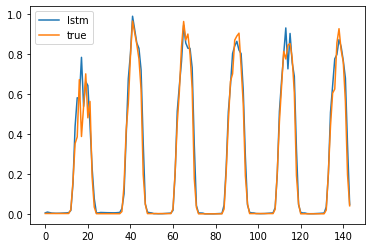

In [132]:
plt.plot(y_hat_lstm, label='lstm')
plt.plot(y_test_lstm, label='true')
plt.legend()

In [133]:
np.savetxt("resultados/arrays/lstm.txt",y_hat_lstm)

# CLSTM

## Train

In [17]:
# from mlopt.mlopt.omodels.ACOLSTM import ACOCLSTM
# # Importing only here becouse TF takes too long to import

# options_ACO={'antNumber':1, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
# X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm = train_test_split(gen, 23,
#                                                                         tr_vd_ts_percents = [80, 20],
#                                                                         print_shapes = True)

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


In [19]:
# Layers_Qtd=[[50, 30, 20, 10], [20, 15, 10], [10, 20], [30, 20], [10, 5]]
# ConvKernels=[[8, 12], [4, 6]]
# epochs=[200]

# clstmOptimizer = ACOCLSTM(X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm,
#                           1 ,options_ACO=options_ACO, verbose=True)

# final_model, y_hat_clstm = clstmOptimizer.optimize(Layers_Qtd = Layers_Qtd, ConvKernels = ConvKernels, epochs=epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

dimentions Ranges passed:  [[50, 30, 20, 10], [8, 12], [20, 15, 10], [4, 6], [10, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [30, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [10, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3], [0]]
Space Created:  [[50  8 20 ...  0  0  0]
 [50  8 20 ...  0  1  0]
 [50  8 20 ...  0  2  0]
 ...
 [10 12 10 ...  5  1  0]
 [10 12 10 ...  5  2  0]
 [10 12 10 ...  5  3  0]]
number of Space Possibilities (rows):  11943936
Setting fitness for
[10 12 20  4 20  0  5 30  0  3  5  5  0  0]


2021-05-28 03:12:22,248 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:12:22,248: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:12:22,341 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:12:22,341: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'elu', 'fl_refunc': 'sigmoid', 'sl_qtn': 30, 'sl_func': 'elu', 'sl_refunc': 'relu', 'tl_qtn': 5, 'tl_func': 'sigmoid', 'optimizer': 'SGD'}
Epoch 1/200
18/18 [==============================] - 34s 99ms/step - loss: 0.3208 - mse: 0.1326
Epoch 2/200
18/18 [==============================] - 2s 98ms/step - loss: 0.1226 - mse: 0.0318
Epoch 3/200
18/18 [==============================] - 2s 97ms/step - loss: 0.1102 - mse: 0.0268
Epoch 4/200
18/18 [==============================] - 2s 100ms/step - loss: 0.0988 - mse: 0.0222
Epoch 5/200
18/18 [==============================] - 2s 101ms/step - loss: 0.0881 - mse: 0.0180 1s - loss: 0.0
Epoch 6/200
18/18 [==============================] - 2s 101ms/step - loss: 0.1012 - mse: 0.0213
Epoch 7/200
18/18 [==============================] - 2s 103ms/step - loss: 0.0847 - mse: 0.0166
Epoch 8/200
18/18 [============================

2021-05-28 03:20:38,420 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:20:38,420: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:20:38,427 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:20:38,427: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


SHAPES output hat: (144,) and test: (144,)
fitness is
0.05694174742907362
Setting fitness for
[10  8 15  6 20  3  4 20  3  5  5  1  2  0]
{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'relu', 'fl_refunc': 'linear', 'sl_qtn': 20, 'sl_func': 'relu', 'sl_refunc': 'sigmoid', 'tl_qtn': 5, 'tl_func': 'selu', 'optimizer': 'rmsprop'}
Epoch 1/200
18/18 [==============================] - 10s 123ms/step - loss: nan - mse: nan
Epoch 2/200
18/18 [==============================] - 2s 130ms/step - loss: nan - mse: nan
Epoch 3/200
18/18 [==============================] - 2s 126ms/step - loss: nan - mse: nan
Epoch 4/200
18/18 [==============================] - 2s 118ms/step - loss: nan - mse: nan
Epoch 5/200
18/18 [==============================] - 2s 128ms/step - loss: nan - mse: nan
Epoch 6/200
18/18 [==============================] - 2s 127ms/step - loss: nan - mse: nan
Epoch 7/200
18/18 [==============================

100%|██████████| 1/1 [16:01<00:00, 961.07s/it]
2021-05-28 03:28:21,233 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:28:21,233: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:28:21,241 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-05-28 03:28:21,241: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Ant 0 possibilities:
[       0        1        2 ... 11943933 11943934 11943935]
Ant 0 move from 10592828 to 1061379
Dij: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Tij: 
[[2.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
Pij:
[[4.437814e-07]
 [8.875628e-08]
 [8.875628e-08]
 ...
 [8.875628e-08]
 [8.875628e-08]
 [8.875628e-08]]
Ants now - then
[1061379] - [10592828]
ACO-All Best Response: [10 12 20  4 20  0  5 30  0  3  5  5  0  0]. Fitness: 0.05694174742907362
{'conv_fl_filters_qtn': 10, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'elu', 'fl_refunc': 'sigmoid', 'sl_qtn': 30, 'sl_func': 'elu', 'sl_refunc': 'relu', 'tl_qtn': 5, 'tl_func': 'sigmoid', 'optimizer': 'SGD'}
Epoch 1/200
18/18 [==============================] - 9s 145ms/step - loss: 0.2457 - mse: 0.1240
Epoch 2/200
18/18 [==============================] - 2s 138ms/step - loss: 0.1897 - mse: 0.0750
Epoch 3/200
18/18 [==============================] - 2s 125ms/step - loss: 0.1

In [22]:
# from sklearn.metrics import mean_absolute_percentage_error

# print("SHAPE y_hat_clstm", y_hat_clstm.shape)

# print('Resultado Dados Teste!')
# print('CLSTM')
# print('MAE: ', mae(y_hat_clstm, y_test_lstm))
# print('MSE: ', mse(y_hat_clstm, y_test_lstm))
# print('MAPE: ', mean_absolute_percentage_error(y_hat_clstm[:], y_test_lstm))

SHAPE y_hat_clstm (144,)
Resultado Dados Teste!
CLSTM
MAE:  0.054690673568596096
MSE:  0.008985202580618162
MAPE:  0.7969261108372311


In [21]:
# final_model.save('./resultados/clstm_model')

2021-05-28 09:29:47,505 - tensorflow - INFO - Assets written to: ./resultados/clstm_model\assets
2021-05-28 09:29:47,505: INFO - Assets written to: ./resultados/clstm_model\assets


## Results

In [137]:
from tensorflow import keras
from sklearn.metrics import mean_absolute_percentage_error

clstm_loadedmodel = keras.models.load_model('./resultados/clstm_model')
_, _, X_test_clstm, y_test_clstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
y_hat_clstm = clstm_loadedmodel.predict(X_test_clstm.reshape((X_test_clstm.shape[0], X_test_clstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('cLSTM')
print('MAE: ', mae(y_hat_clstm, y_test_clstm))
print('MSE: ', mse(y_hat_clstm, y_test_clstm))
print('MAPE: ', mean_absolute_percentage_error(y_hat_clstm, y_test_clstm))

2021-10-21 08:08:43,530 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-21 08:08:43,530: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-21 08:08:43,551 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-21 08:08:43,551: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/conv1d (defined at <ipython-input-137-70a6d9ac8826>:6) ]] [Op:__inference_predict_function_26298]

Function call stack:
predict_function


In [135]:
plt.plot(y_hat_clstm[:,0], label='clstm')
plt.plot(y_test_clstm, label='true')
plt.legend()

NameError: name 'y_hat_clstm' is not defined

In [ ]:
np.savetxt("resultados/arrays/clstm.txt",y_test_clstm)

# MMFF

## train

In [10]:
from mlopt.MMFFBleding_Regressor import MMFFBleding
X_train_blender, y_train_blender, X_test_blender, y_test_blender = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (576, 23)
y_train:  (576, 1)
X_test:  (144, 23)
y_test:  (144, 1)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

MMFF_model = MMFFBleding(X_train_blender, y_train_blender, X_test_blender, y_test_blender, LinearRegression())
MMFF_model.train()
y_hat_blender = MMFF_model.predict(X_test_blender)

print('Resultado Dados Teste!')
print('MMFF')
print('MAE: ', mae(y_hat_blender, y_test_blender))
print('MSE: ', mse(y_hat_blender, y_test_blender))
print('MAPE: ', MAPE(y_hat_blender, y_test_blender))

Train: (576, 23), Test: (144, 23)
Resultado Dados Teste!
MMFF
MAE:  0.05039607987380244
MSE:  0.007926807599215553
MAPE:  1.7874036144422343


In [15]:
pickle.dump(MMFF_model, open('resultados/best_blender_trained.pckl', 'wb'))

## results

In [25]:
MMFF_model_loaded = pickle.load(open('resultados/best_blender_trained.pckl', 'rb'))

y_hat_blender = MMFF_model_loaded.predict(X_test_blender)

print('Resultado Dados Teste!')
print('MMFF')
print('MAE: ', mae(y_hat_blender, y_test_blender))
print('MSE: ', mse(y_hat_blender, y_test_blender))
print('MAPE: ', MAPE(y_hat_blender, y_test_blender))

Resultado Dados Teste!
MMFF
MAE:  0.05039607987380244
MSE:  0.007926807599215553
MAPE:  1.7874036144422343


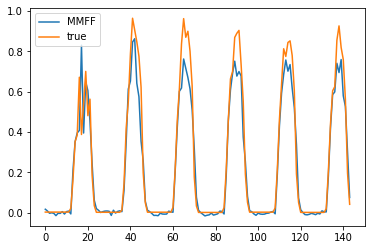

In [42]:
plt.plot(y_hat_blender, label='MMFF')
plt.plot(y_test_blender, label='true')
plt.legend()

In [ ]:
np.savetxt("resultados/arrays/mmff.txt",y_hat_blender)

# NARNN - ARMAX

With neural_prophet

## Train

In [59]:
df_narnn = pd.DataFrame()
df_narnn["y"] = df_inmet['radiacao_global_wpm2']/df_inmet['radiacao_global_wpm2'].max()
df_narnn["ds"] = pd.to_datetime(df_inmet.data.astype('str') + ' ' + df_inmet.hora.astype('str')+":00:00")
df_narnn.reset_index(inplace=True, drop=True)

In [60]:
df_narnn

y                  ds
0    0.117778 2020-03-12 20:00:00
1    0.011912 2020-03-12 21:00:00
2    0.011912 2020-03-12 22:00:00
3    0.011912 2020-03-12 23:00:00
4    0.011912 2020-03-13 00:00:00
..        ...                 ...
716  0.819514 2020-04-11 16:00:00
717  0.760146 2020-04-11 17:00:00
718  0.561915 2020-04-11 18:00:00
719  0.196944 2020-04-11 19:00:00
720  0.041952 2020-04-11 20:00:00

[721 rows x 2 columns]

In [66]:
from neuralprophet import NeuralProphet

narnn_model = NeuralProphet(n_forecasts=1,n_lags=24,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)

In [75]:
narnn_model.fit(df_narnn, freq='H')
future = narnn_model.make_future_dataframe(df_narnn, periods=0, n_historic_predictions=len(df_narnn))
df_predicted = narnn_model.predict(future)

WARNING - (NP.forecaster.fit) - Model has already been fitted. Re-fitting will produce different results.
2021-10-20 22:20:45,667 - NP.forecaster - WARNING - Model has already been fitted. Re-fitting will produce different results.
2021-10-20 22:20:45,667: WARNING - Model has already been fitted. Re-fitting will produce different results.
Epoch[196/196]: 100%|██████████| 196/196 [00:15<00:00, 12.98it/s, SmoothL1Loss=0.00543, MAE=0.0535, MSE=0.00781, RegLoss=0]
WARNING - (NP.forecaster.single_make_future_dataframe) - Insufficient data for 721 historic forecasts, reduced to 697.
2021-10-20 22:21:00,804 - NP.forecaster - WARNING - Insufficient data for 721 historic forecasts, reduced to 697.
2021-10-20 22:21:00,804: WARNING - Insufficient data for 721 historic forecasts, reduced to 697.


In [76]:
print(df_predicted.iloc[0:20,:])
print(df_predicted.iloc[-20:,:])

                    ds         y yhat1 residual1   ar1 trend season_daily
0  2020-03-12 20:00:00  0.117778  None       NaN  None  None         None
1  2020-03-12 21:00:00  0.011912  None       NaN  None  None         None
2  2020-03-12 22:00:00  0.011912  None       NaN  None  None         None
3  2020-03-12 23:00:00  0.011912  None       NaN  None  None         None
4  2020-03-13 00:00:00  0.011912  None       NaN  None  None         None
5  2020-03-13 01:00:00  0.011912  None       NaN  None  None         None
6  2020-03-13 02:00:00  0.011912  None       NaN  None  None         None
7  2020-03-13 03:00:00  0.011912  None       NaN  None  None         None
8  2020-03-13 04:00:00  0.011912  None       NaN  None  None         None
9  2020-03-13 05:00:00  0.011912  None       NaN  None  None         None
10 2020-03-13 06:00:00  0.011912  None       NaN  None  None         None
11 2020-03-13 07:00:00  0.011912  None       NaN  None  None         None
12 2020-03-13 08:00:00  0.011912  None

<AxesSubplot:xlabel='ds'>

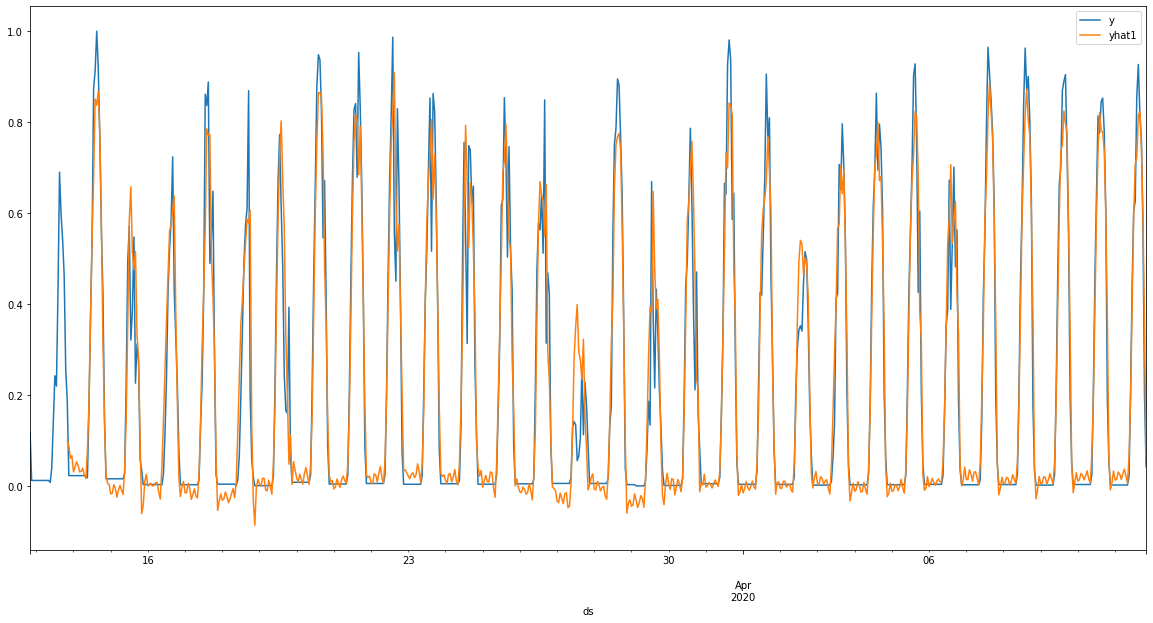

In [93]:
df_predicted.plot(x="ds", y=["y","yhat1"], figsize=(20,10))

In [115]:
pm.auto_arima(y=df_predicted["y"].iloc[24:].values.astype("float"), X=df_predicted["yhat1"].iloc[24:].values.astype("float").reshape(-1, 1),
              seasonal=False,
              maxiter=50,
              trace=True,
              max_order=30,
              n_fits=50,
              stepwise=True,
              max_d=3,
              information_criterion="aicc")

Performing stepwise search to minimize aicc
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=-1391.896, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=-1399.999, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=-1397.982, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=-1397.982, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=-1395.959, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AICC=-1398.001, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.921 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [114]:
df_predicted["yhat1"].iloc[24:].values

array([0.10108332335948944, 0.08778038620948792, 0.060505010187625885,
       0.06647833436727524, 0.03069925121963024, 0.041290901601314545,
       0.05292264372110367, 0.04503593221306801, 0.03047066368162632,
       0.032115012407302856, 0.03895450383424759, 0.023496117442846298,
       0.01614769548177719, 0.07955162972211838, 0.18088635802268982,
       0.3648167848587036, 0.5465314984321594, 0.6794398427009583,
       0.8507611751556396, 0.8369469046592712, 0.8683403730392456,
       0.776665210723877, 0.5854784250259399, 0.31786206364631653,
       0.14225517213344574, 0.02319466508924961, 0.005547821521759033,
       0.0030929986387491226, -0.017450356855988503,
       -0.016732122749090195, 0.0026608952321112156,
       -0.005219076294451952, -0.02460605278611183, -0.009938815608620644,
       0.0010701772989705205, -0.008797727525234222,
       -0.018984073773026466, 0.031850140541791916, 0.1469109058380127,
       0.35351505875587463, 0.5826091766357422, 0.6577799916267395,


In [118]:
mod = SARIMAX(endog=df_predicted["y"].iloc[24:].values.astype("float"),
              exog=df_predicted["yhat1"].iloc[24:].values.astype("float").reshape(-1,1),
              order=(0,0,0),
              seasonal_order=(0,0,0,0))

results = mod.fit(disp=True)
y_armax_narnn = results.predict()
mape_autoarima = MAPE(df_predicted["y"].iloc[24:].values.astype("float"), y_armax_narnn, threshold=0.1)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -1399.9994492338494, Mape: 26.67544851632846


## Results

In [119]:
from sklearn.metrics import mean_absolute_percentage_error as MAPESK

In [120]:
y_test_ = df_predicted["y"].iloc[-int(len(df_predicted)*0.2):]
y_armax_narnn_test = y_armax_narnn[-len(y_test_):]

In [122]:
print('Resultado Dados Teste!')
print('LSRM-ARMAX')
print('MAE: ', mae(y_test_, y_armax_narnn_test))
print('MSE: ', mse(y_test_, y_armax_narnn_test))
print('MAPE: ', MAPESK(y_test_, y_armax_narnn_test))

Resultado Dados Teste!
LSRM-ARMAX
MAE:  0.04010140370387125
MSE:  0.004156724057393788
MAPE:  3.0723149053989003


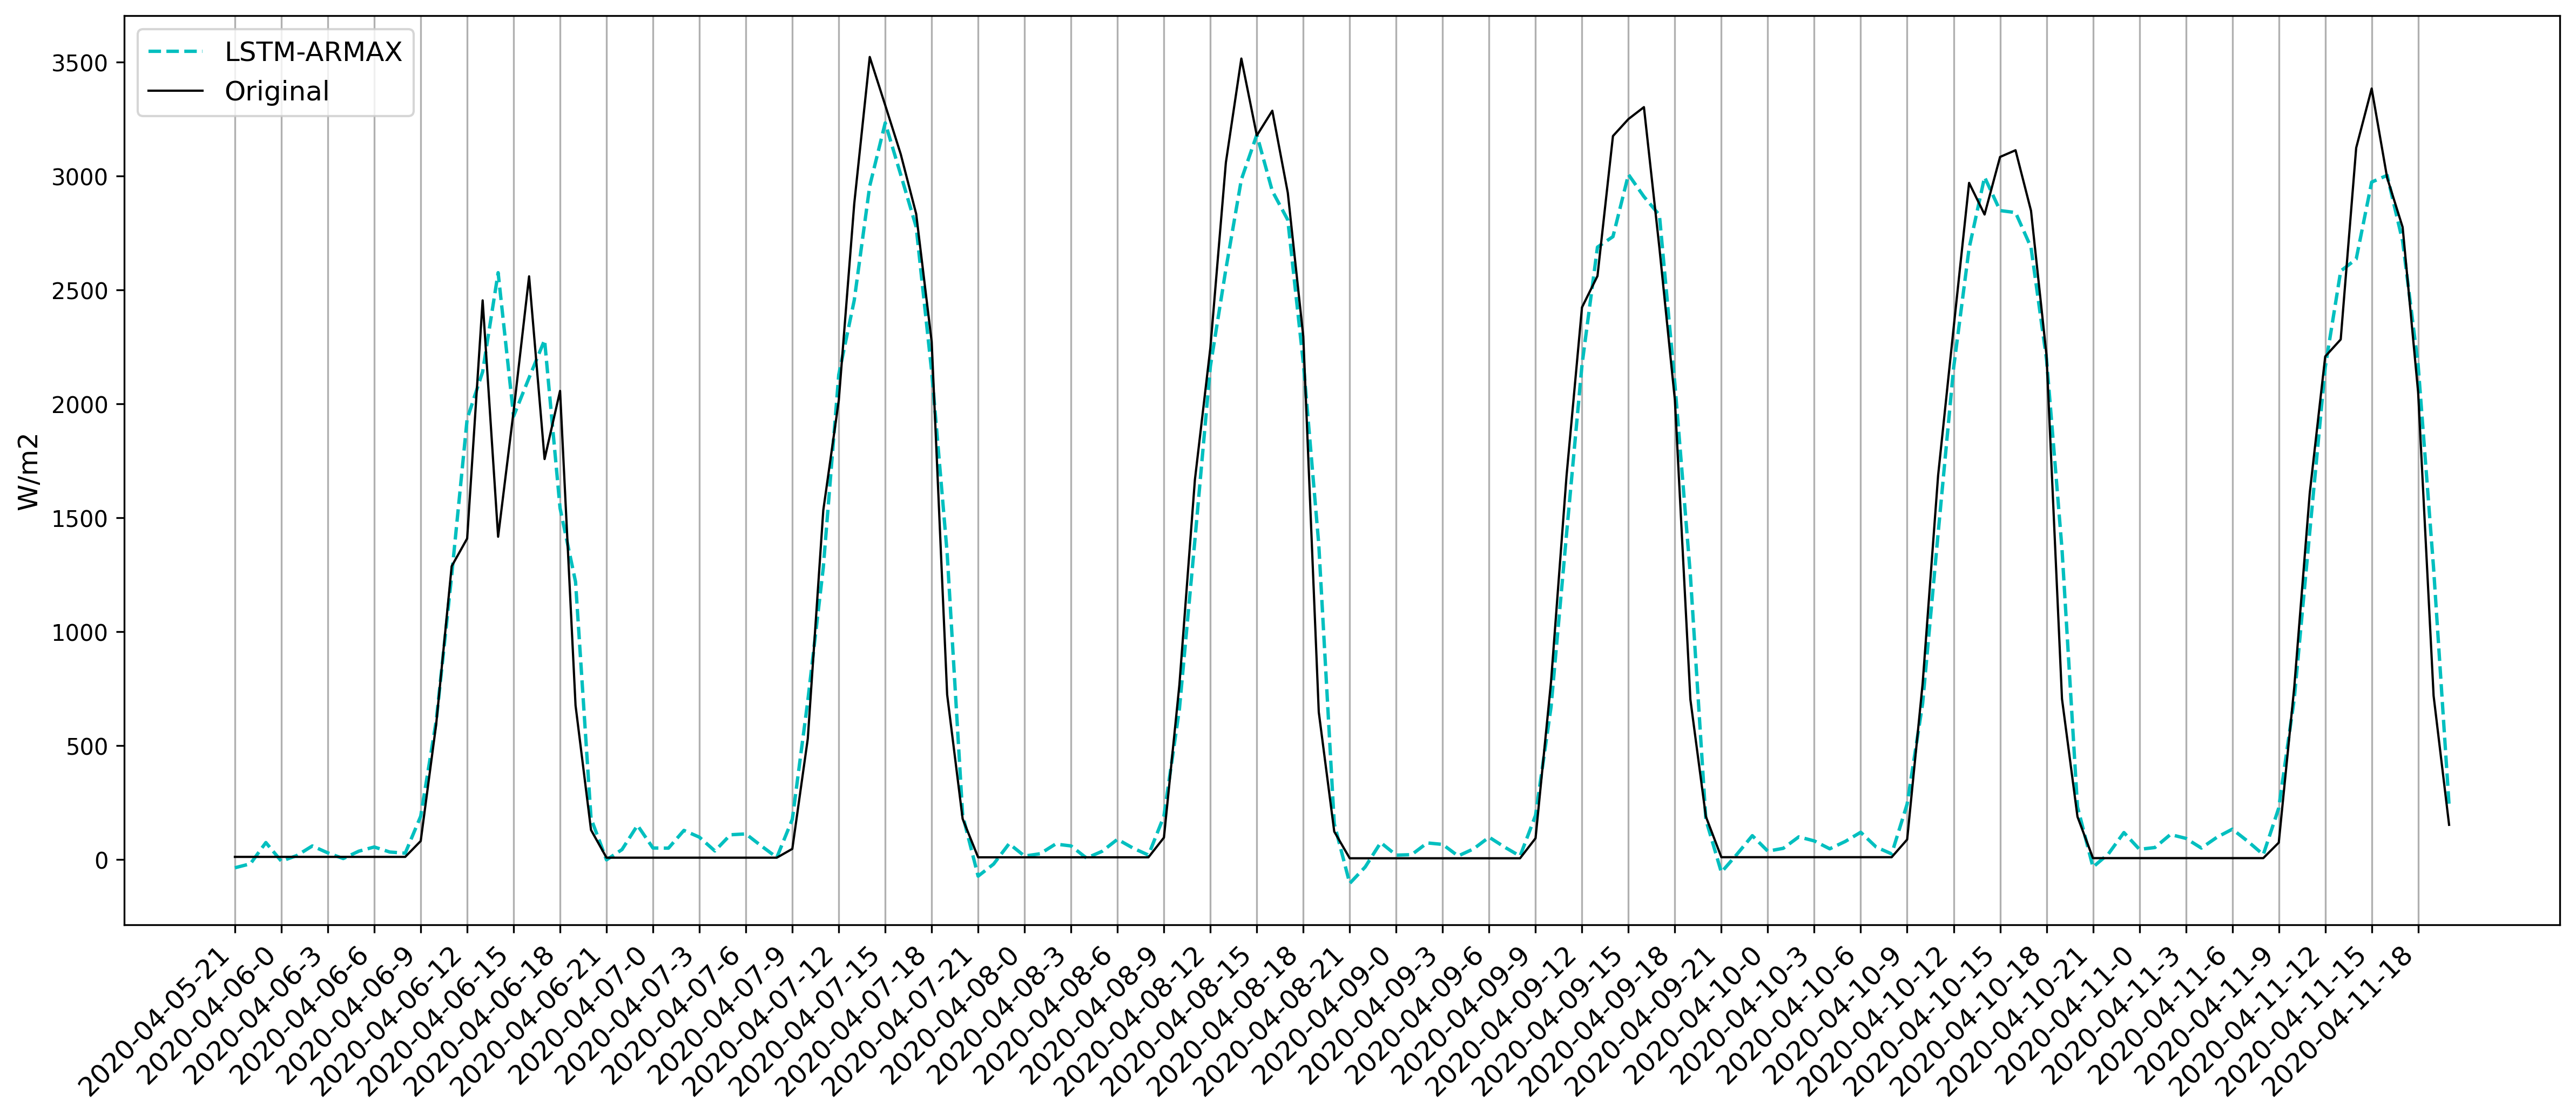

In [123]:
len_dt = len(y_test_)

fig, ax = plt.subplots(1,1, figsize=(16,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_armax_narnn_test[-len_dt:].reshape(-1, 1)), 'c--', label='LSTM-ARMAX')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Original',
       linewidth=1)

plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/lstm_armax_test.png', dpi=300)

In [ ]:
np.savetxt("resultados/arrays/narnn_armax.txt",y_armax_narnn_test[-len_dt:].reshape(-1, 1)))

# Figura Unica

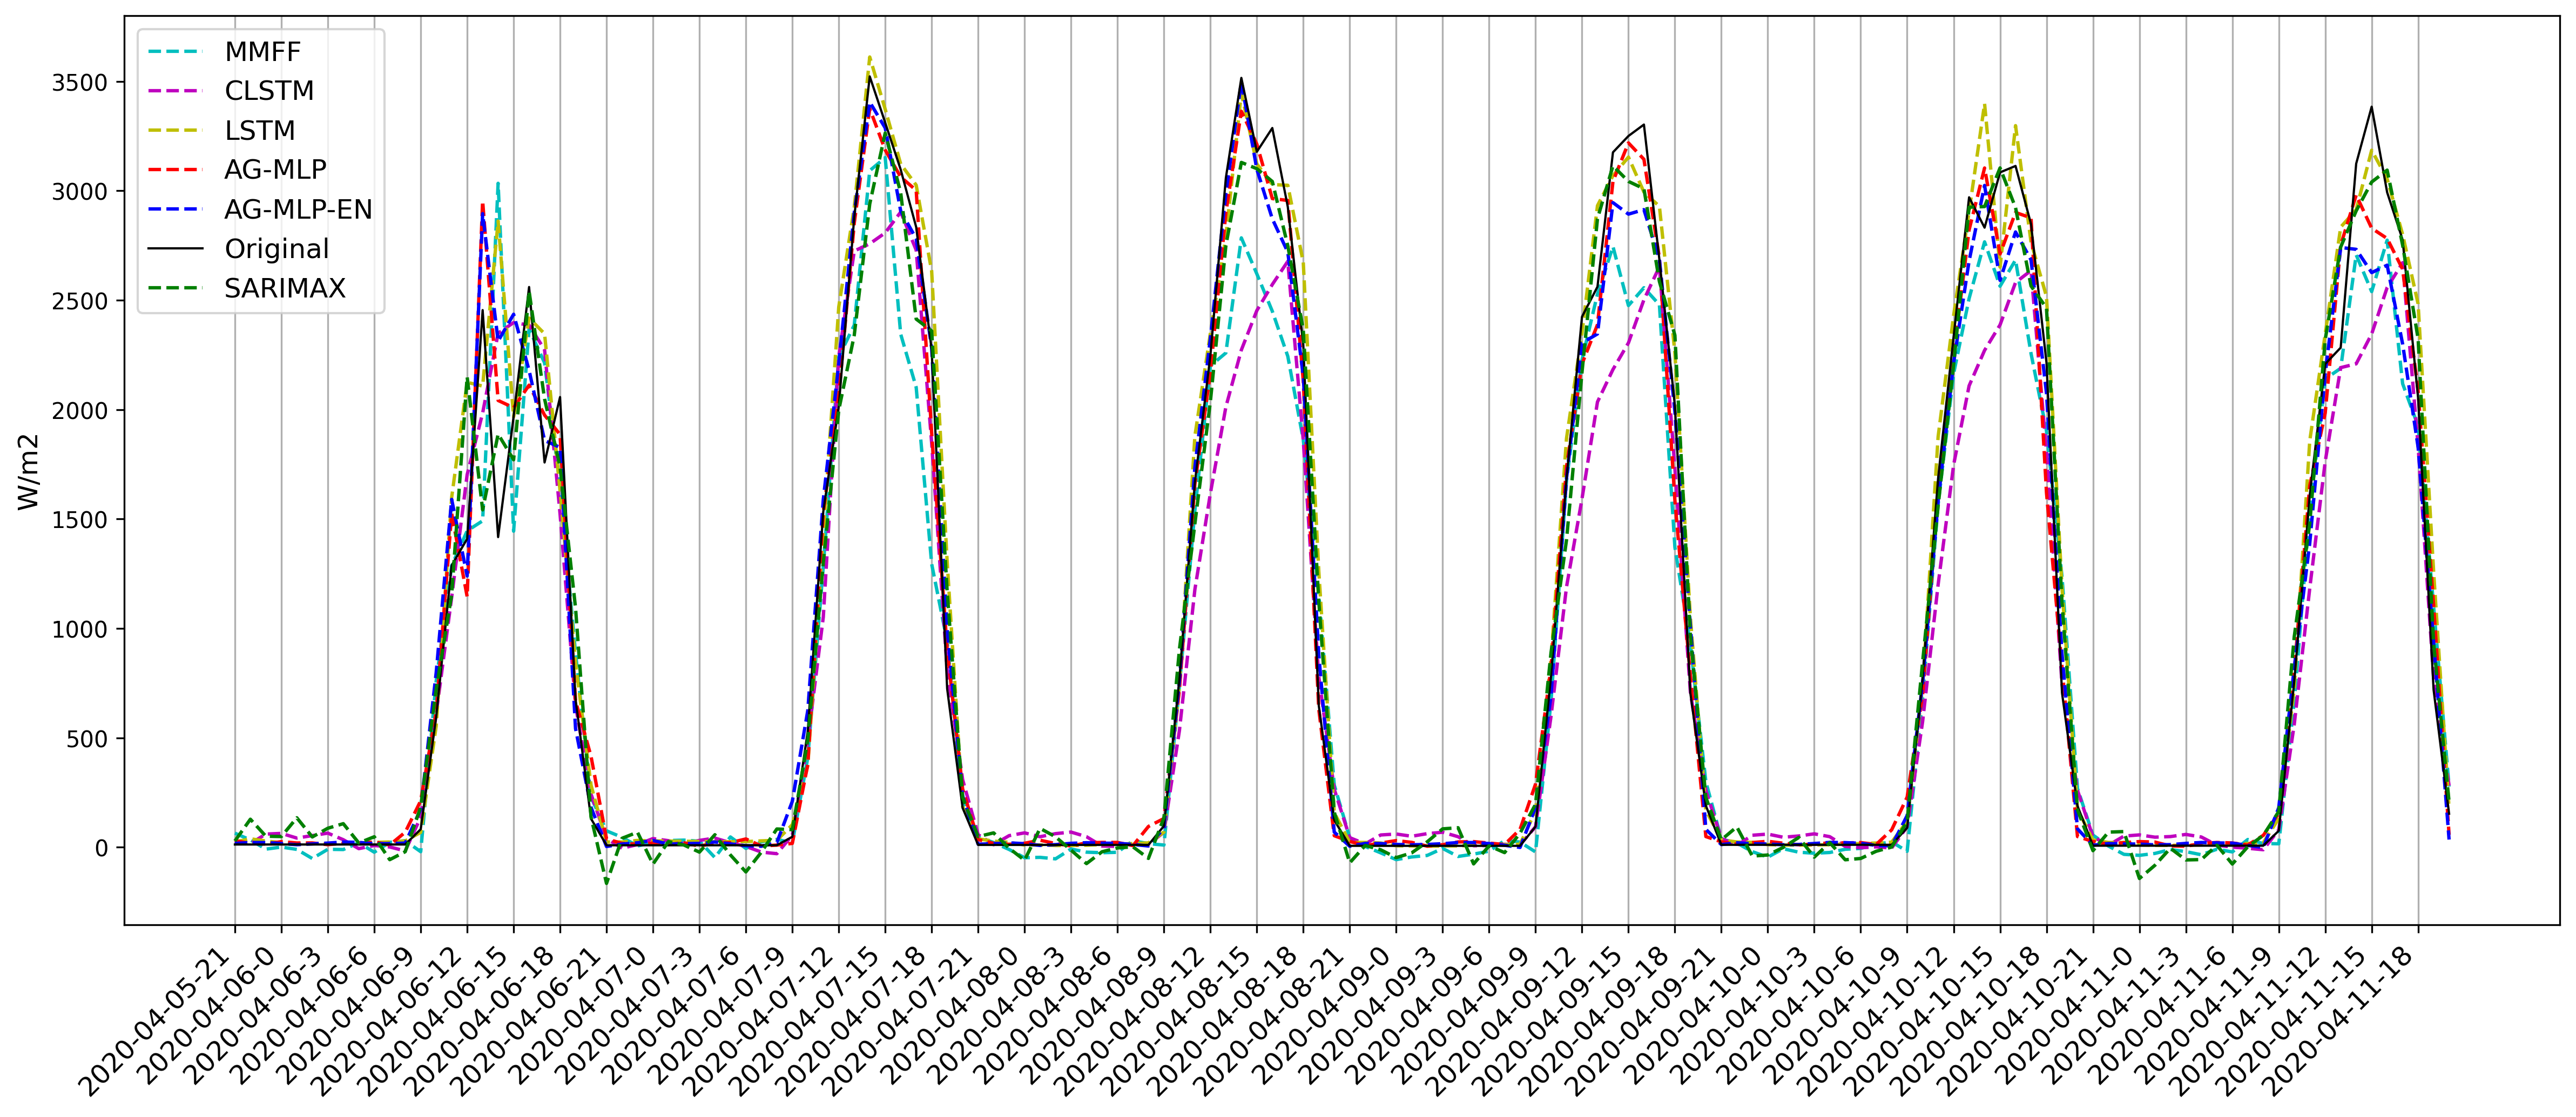

In [45]:
fig, ax = plt.subplots(1,1, figsize=(16,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_blender[-len_dt:].reshape(-1, 1)), 'c--', label='MMFF')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_clstm[-len_dt:].reshape(-1, 1)), 'm--', label='CLSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_lstm[-len_dt:].reshape(-1, 1)), 'y--', label='LSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_armax_narnn_test[-len_dt:].reshape(-1, 1)),'b--',label='NARNN-ARMAX')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_residual[-len_dt:].reshape(-1, 1)), 'r--', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-len_dt:].reshape(-1, 1)),'b--',label='AG-MLP-EN')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Test Data',linewidth=1)
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--', label='SARIMAX')

plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids_test.png', dpi=300)